# Imports

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

cuda


# Data Loading

In [2]:
data_df = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.drop(columns=['article_link'], inplace=True)
data_df.shape

(26708, 2)

In [3]:
data_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


# Data Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df['headline']), np.array(data_df['is_sarcastic']), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

print('Training Size: ', X_train.shape[0], 'Which is: ', round(X_train.shape[0]/data_df.shape[0], 4) * 100, '%')
print('Validation Size: ', X_val.shape[0], 'Which is: ', round(X_val.shape[0]/data_df.shape[0], 4) * 100, '%')
print('Training Size: ', X_test.shape[0], 'Which is: ', round(X_test.shape[0]/data_df.shape[0], 4) * 100, '%')

Training Size:  18695 Which is:  70.0 %
Validation Size:  4006 Which is:  15.0 %
Training Size:  4007 Which is:  15.0 %


In [5]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2025-10-31 01:48:12.653299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761875292.854166     100 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761875292.912340     100 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Custom Dataset Class

In [17]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = [tokenizer(x,
                        max_length = 100,
                        truncation = True,
                        padding = 'max_length',
                        return_tensors = 'pt')
                        for x in X
    ]
    self.Y = torch.tensor(Y, dtype=torch.float32)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

# Create Dataset Objects

In [18]:
training_dataset = dataset(X_train, y_train)
validation_dataset = dataset(X_val, y_val)
test_dataset = dataset(X_test, y_test)

# Hyperparameters

In [34]:
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-4

# Dataloaders

In [29]:
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [35]:
class MyModel(nn.Module):
  def __init__(self, bert):
    super(MyModel, self).__init__()

    self.bert = bert
    self.linear1 = nn.Linear(768, 384)
    self.bn1 = nn.BatchNorm1d(384)
    self.dropout= nn.Dropout(0.5)
    self.linear2 = nn.Linear(384, 128)
    self.bn2 = nn.BatchNorm1d(128)
    self.dropout2 = nn.Dropout(0.25)
    self.linear3 = nn.Linear(128, 1)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()

  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(input_ids, attention_mask, return_dict=False) [0][:,0]
    output = self.linear1(pooled_output)
    output = self.bn1(output)
    output = self.relu(output)
    output = self.dropout(output)

    output = self.linear2(output)
    output = self.bn2(output)
    output = self.relu(output)
    output = self.dropout(output)

    output = self.linear3(output)
    output = self.sigmoid(output)
    return output

In [36]:
for param in bert_model.parameters():
  param.requires_grad = False
model = MyModel(bert_model).to(device)

In [37]:
# Model Architecture
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

# Loss Function and Optimizer

In [38]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=0.01)

# Training

In [42]:
total_loss_train_plot = []
total_acc_train_plot = []
total_loss_val_plot = []
total_acc_val_plot = []

best_val_score = 0.0
patience = 3
patience_counter = 0

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0
    
  if epoch == 3:
      for name, param in model.named_parameters():
          if any(f'layer.{i}' in name for i in range(10, 12)):
              param.requires_grad = True

  for inputs, labels in train_loader:
    input_ids = inputs['input_ids'].squeeze(1).to(device)
    attention_mask = inputs['attention_mask'].squeeze(1).to(device)
    labels = labels.to(device)

    outputs = model(input_ids, attention_mask).squeeze(1)

    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    acc = (outputs.round() == labels).sum().item()
    total_acc_train += acc

    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs, labels in validation_loader:
      input_ids = inputs['input_ids'].squeeze(1).to(device)
      attention_mask = inputs['attention_mask'].squeeze(1).to(device)
      labels = labels.to(device)

      outputs = model(input_ids, attention_mask).squeeze(1)

      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()
      acc = (outputs.round() == labels).sum().item()
      total_acc_val += acc

  # Saving for plots
  train_loss = total_loss_train / len(train_loader)
  val_loss = total_loss_val / len(validation_loader)
  acc_train = (total_acc_train / len(training_dataset)) * 100
  acc_val = (total_acc_val / len(validation_dataset)) * 100

  total_loss_train_plot.append(round(train_loss, 4))
  total_loss_val_plot.append(round(val_loss, 4))
  total_acc_train_plot.append(round(acc_train, 4))
  total_acc_val_plot.append(round(acc_val, 4))

  print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(train_loss,4)} Train Accuracy: {round(acc_train,4)}%"
        f"Validation Loss: {round(val_loss,4)} Validation Accuracy: {round(acc_val,4)}%")
  print("="*70)

Epoch 1/5, Train Loss: 0.2967 Train Accuracy: 87.3496%Validation Loss: 0.3049 Validation Accuracy: 86.4953%
Epoch 2/5, Train Loss: 0.2937 Train Accuracy: 87.6812%Validation Loss: 0.3016 Validation Accuracy: 87.2691%
Epoch 3/5, Train Loss: 0.2749 Train Accuracy: 88.4568%Validation Loss: 0.3032 Validation Accuracy: 86.1707%
Epoch 4/5, Train Loss: 0.2881 Train Accuracy: 87.8256%Validation Loss: 0.2963 Validation Accuracy: 87.7434%
Epoch 5/5, Train Loss: 0.2561 Train Accuracy: 89.5266%Validation Loss: 0.2799 Validation Accuracy: 88.3674%


# Testing

In [43]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in test_loader:
    input_ids = inputs['input_ids'].squeeze(1).to(device)
    attention_mask = inputs['attention_mask'].squeeze(1).to(device)
    labels = labels.to(device)

    predictions = model(input_ids, attention_mask).squeeze(1)

    val_loss = criterion(predictions, labels)
    total_loss_test += val_loss.item()
    acc = (predictions.round() == labels).sum().item()
    total_acc_test += acc

print(f'Loss Score is: {round(total_loss_test/len(test_loader), 4)} and Accuracy is: {round(total_acc_test/test_dataset.__len__()*100, 4)}')

Loss Score is: 0.2782 and Accuracy is: 88.6948


# Plotting Training Progress

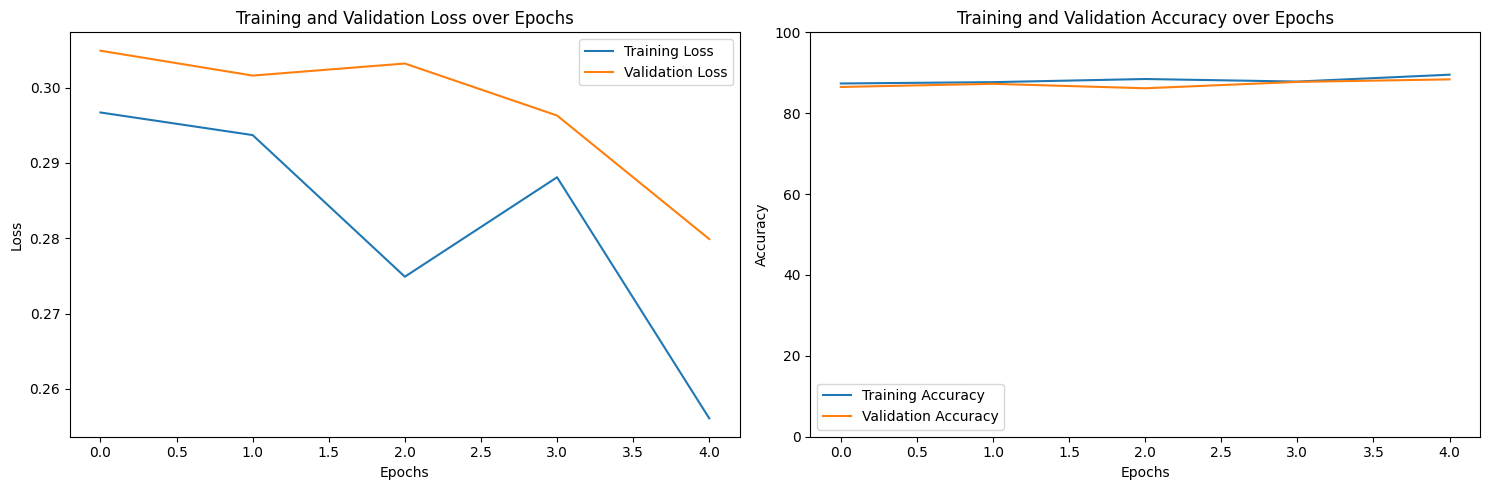

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()